<a href="https://colab.research.google.com/github/abduhsalam/Suicide-Prevention-DTI/blob/main/Suicide_Prevention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install nltk
!pip install keras
!pip install spacy
!pip install googletrans
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
import pandas as pd

# read csv file 1
df1 = pd.read_csv('https://raw.githubusercontent.com/hesamuel/goodbye_world/master/data/data_for_model_2.csv', sep=',')
df1 = df1.drop(['url', 'num_comments', 'author', 'title', 'selftext', 'selftext_clean', 'title_clean', 'author_clean', 'selftext_length', 'title_length'], axis=1)
df1 = df1.dropna()
df1.head()

,is_suicide,megatext_clean
0,0,sql witch understand people reply immediately ...
1,0,c irc welcome r depression check post place ta...
2,0,new killer 69 feeling really depressed lonely ...
3,0,jazz le crab literally broke cry asked go home...
4,0,depressed kid 786 kind soul want give depresse...


In [23]:
#read csv file 2
df2 = pd.read_csv('https://raw.githubusercontent.com/reetika-goel/Predict-Suicidal-Ideation-Based-on-Tweets/master/PredictSuicidalIdeationBasedonTweets/Train_suicide1.csv', sep=',')
df2.loc[df2['Suicide'] == "Potential Suicide post ", "Suicide"] = 1
df2.loc[df2['Suicide'] == "Not Suicide post", "Suicide"] = 2
df2 = df2.rename(columns = {'Tweet': 'megatext_clean', 'Suicide': 'is_suicide'}, inplace = False)
df2.is_suicide.astype('int')
df2.head()

,megatext_clean,is_suicide
0,i hate myself so much i want to KILL myself ho...,1
1,RT @DrugForumsBest: I woke up with a bag over ...,1
2,i wanna fucking kill myself,1
3,why do i destroy all my opportunities? am i go...,1
4,u - understand what the fuck im doing wrong wi...,1


In [24]:
# Combine data
df = pd.concat([df1, df2], ignore_index=True, sort=False)
df.shape

(3496, 2)

In [25]:
df = df.dropna()
df.isnull().sum()

is_suicide        0
megatext_clean    0
dtype: int64

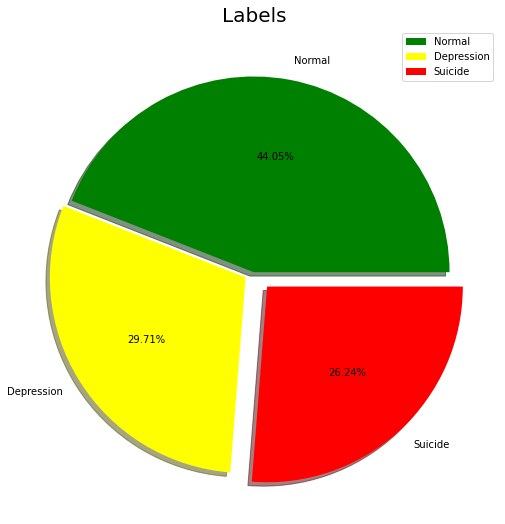

In [26]:
import matplotlib.pyplot as plt

labels = ['Normal', 'Depression','Suicide']
size = df['is_suicide'].value_counts()
colors = ['green', 'yellow','red']
explode = [0, 0.05, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Labels', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

**Text Preprocessing**

In [27]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

# Case Folding
# Convert text to lowercase
df['megatext_clean'] = df['megatext_clean'].str.lower()

# Remove Twitter megatext_clean Link and RT word
df['megatext_clean'] = df['megatext_clean'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'rt', '', regex=True)

# Remove number
df['megatext_clean'] = df['megatext_clean'].str.replace('\d+', '')

# Remove Punctuation
df['megatext_clean'] = df['megatext_clean'].str.replace('[^\w\s]','')

# Remove Whitespaces
df["megatext_clean"] = df['megatext_clean'].str.strip()

# Tokenization
df["megatext_clean"] = df["megatext_clean"].apply(nltk.word_tokenize)

# StopWords Removal
stop_words = set(stopwords.words('english'))
df["megatext_clean"] = df["megatext_clean"].apply(lambda x: [item for item in x if item not in stop_words])

# Stemming
ps = PorterStemmer()
df['megatext_clean'] = df['megatext_clean'].apply(lambda x: [ps.stem(item) for item in x])

# Lemmetizer
lemmatizer = WordNetLemmatizer()
df['megatext_clean'] = df['megatext_clean'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])

df.shape

(3494, 2)

**Suicide megatext_clean Word Cloud**

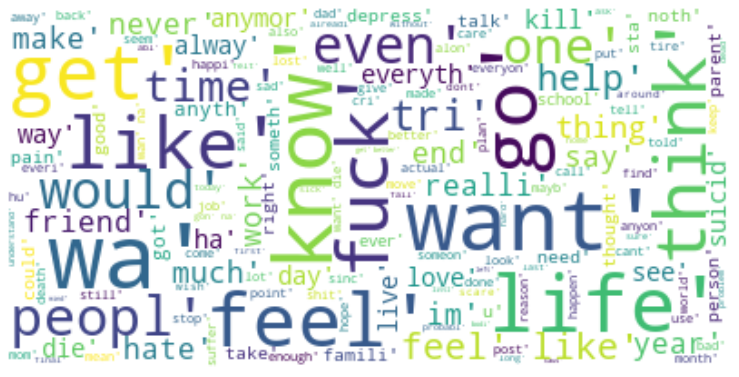

In [28]:
from os import path
from PIL import Image
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")

# Create and generate a word cloud image:
word = df.megatext_clean[df['is_suicide']== 1].astype('string')
word.head()
wordcloud = WordCloud(max_font_size=50, max_words=150, background_color="white").generate_from_text(' '.join(word))

# Display the generated image:
plt.figure(figsize=(13,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Depression megatext_clean Word Cloud**

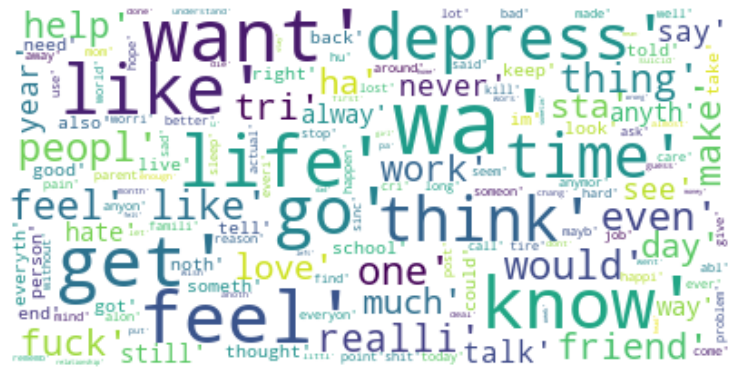

In [29]:
# Create and generate a word cloud image:
word = df.megatext_clean[df['is_suicide']== 0].astype('string')
word.head()
wordcloud = WordCloud(max_font_size=50, max_words=150, background_color="white", ).generate_from_text(' '.join(word))

# Display the generated image:
plt.figure(figsize=(13,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
vocab_size = 5000 # make the top list of words (common words)
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary
training_portion = .8

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['megatext_clean'], df['is_suicide'], test_size=0.2, random_state=1000)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(2795,) (2795,)
(699,) (699,)


In [32]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [33]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train.astype('str'))

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train.astype('str')))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test.astype('str')))

label_tokenizer.word_index

{'0': 3, '1': 1, '2': 2}

In [34]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(30, activation="relu"))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3870      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 124       
Total params: 390,042
Trainable params: 390,042
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

history = model.fit(train_padded, training_label_seq, epochs=10, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
88/88 - 2s - loss: 0.8764 - accuracy: 0.5188 - val_loss: 0.6956 - val_accuracy: 0.6009
Epoch 2/10
88/88 - 2s - loss: 0.5818 - accuracy: 0.6798 - val_loss: 0.7023 - val_accuracy: 0.6352
Epoch 3/10
88/88 - 2s - loss: 0.4709 - accuracy: 0.7692 - val_loss: 0.6033 - val_accuracy: 0.6781
Epoch 4/10
88/88 - 2s - loss: 0.3317 - accuracy: 0.8583 - val_loss: 0.5903 - val_accuracy: 0.7225
Epoch 5/10
88/88 - 2s - loss: 0.2313 - accuracy: 0.9102 - val_loss: 0.6987 - val_accuracy: 0.7282
Epoch 6/10
88/88 - 2s - loss: 0.1599 - accuracy: 0.9377 - val_loss: 0.7954 - val_accuracy: 0.7210
Epoch 7/10
88/88 - 2s - loss: 0.1209 - accuracy: 0.9624 - val_loss: 0.8678 - val_accuracy: 0.7124
Epoch 8/10
88/88 - 2s - loss: 0.0904 - accuracy: 0.9685 - val_loss: 1.0181 - val_accuracy: 0.7124
Epoch 9/10
88/88 - 2s - loss: 0.0706 - accuracy: 0.9792 - val_loss: 1.1205 - val_accuracy: 0.7124
Epoch 10/10
88/88 - 2s - loss: 0.0557 - accuracy: 0.9839 - val_loss: 1.2677 - val_accuracy: 0.7010


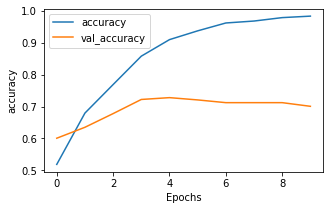

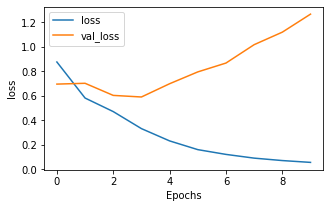

In [41]:
def plot_graphs(history, string):
  plt.rcParams['figure.figsize'] = (5, 3)
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [43]:
model.save('English Suicide Prevention Model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: English Suicide Prevention Model/assets
